# Select practices prescibing nimodipine meeting eligibility criteria

## 1. Import all nimodipine data, filtering out closed and small practices

In [9]:

# Set dates of baseline and follow-up periods
d5 = '2020-03-01' # month after end of follow-up period (6 months)
d4 = '2019-09-01' # follow-up start
d3 = '2019-04-01' # month after end of baseline period
d2 = '2019-01-01' # start of 3-month baseline period
d1 = '2018-04-01' # start of 12-month baseline period


# import data for all practices prescribing nimodipine, 
# excluding those which are dormant/closed,
# excluding practices which are not standard general practices
# excluding practices in Devon CCG (or one of its predecessor organisations NEW Devon CCG)

# Import dataset from BigQuery
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''
WITH a AS (
SELECT * FROM 
`ebmdatalab.hscic.normalised_prescribing_standard` 
WHERE SUBSTR(bnf_code,1,9) = '0206020M0'
AND EXTRACT(year FROM month) > 2017 )

SELECT  
    a.practice,
    a.pct,
    setting,
    a.month,
    total_list_size,
    SUM(a.items) AS items,
    SUM(a.quantity) AS quantity
FROM a
   INNER JOIN hscic.practices b ON a.practice = b.code AND setting=4 
   INNER JOIN `hscic.practice_statistics_all_years` pop  ON a.practice = pop.practice AND a.month = pop.month and status_code = "A"
WHERE pct NOT IN ('99P','15N')
    AND pop.total_list_size > 1000 
    AND (male_25_34 + male_35_44 + male_45_54 + male_55_64 + female_25_34 + female_35_44 + female_45_54 + female_55_64)
    / total_list_size BETWEEN 0.1 and 0.85
GROUP BY practice, pct, setting, month, total_list_size
'''
df1 = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

        ## note: parsing dates is quite memory-intensive, make sure not too many programmes running

df1["month"] = pd.to_datetime(df1.month)

df1.head() # this gives the first few rows of data

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice,pct,setting,month,total_list_size,items,quantity
0,L81054,15C,4,2018-11-01 00:00:00+00:00,11072,4,224
1,K83002,03V,4,2018-05-01 00:00:00+00:00,48471,1,112
2,M88002,05L,4,2018-07-01 00:00:00+00:00,8889,2,228
3,L81669,15C,4,2018-09-01 00:00:00+00:00,5567,1,120
4,G82050,09C,4,2018-12-01 00:00:00+00:00,20738,1,60


## 2. Categorise date periods

In [10]:
### classify data by baseline period
import datetime

'''
Dates as defined above:
d3 = '2019-04-01' # month after end of baseline period
d2 = '2019-01-01' # start of 3-month baseline period
d1 = '2018-04-01' # start of 12-month baseline period
'''

df1["12-mo-baseline"] = False
df1["3-mo-baseline"] = False
df1.loc[(df1['month']>=d1)&(df1['month']<d3), "12-mo-baseline"] = True
df1.loc[(df1['month']>=d2)&(df1['month']<d3), "3-mo-baseline"] = True

df1.head(10)

,practice,pct,setting,month,total_list_size,items,quantity,12-mo-baseline,3-mo-baseline
0,L81054,15C,4,2018-11-01 00:00:00+00:00,11072,4,224,True,False
1,K83002,03V,4,2018-05-01 00:00:00+00:00,48471,1,112,True,False
2,M88002,05L,4,2018-07-01 00:00:00+00:00,8889,2,228,True,False
3,L81669,15C,4,2018-09-01 00:00:00+00:00,5567,1,120,True,False
4,G82050,09C,4,2018-12-01 00:00:00+00:00,20738,1,60,True,False
5,E82074,06K,4,2018-05-01 00:00:00+00:00,20385,8,336,True,False
6,C82027,04V,4,2018-01-01 00:00:00+00:00,7310,1,28,False,False
7,D82067,06M,4,2019-02-01 00:00:00+00:00,12920,1,60,True,True
8,B86081,15F,4,2018-10-01 00:00:00+00:00,14244,1,84,True,False
9,C82051,04V,4,2018-05-01 00:00:00+00:00,11200,1,56,True,False


## 3. Group data and select practices meeting inclusion criteria for latest 3 and 12-month prescribing periods

In [11]:

# any prescribing in last 3 months
filter1 = df1.loc[df1["3-mo-baseline"]==True].groupby(["practice"])["items","quantity","total_list_size"].agg({"items":"sum","quantity":"sum","total_list_size":"mean"}).reset_index()
filter1 = filter1.rename(columns={"items":"3-mo_items","quantity":"3-mo_quantity", "total_list_size":"3-mo_total_list_size"})

#sum over 12 months
agg = df1.loc[df1["12-mo-baseline"]==True].groupby(["practice"])["items","quantity","total_list_size"].agg({"items":"sum","quantity":"sum","total_list_size":"mean"}).reset_index()

agg = agg.merge(filter1, on="practice", how="inner")#.groupby(["practice","3-mo-baseline"]).sum()
agg = agg.rename(columns={"items":"12-mo_items","quantity":"12-mo_quantity", "total_list_size":"12-mo_total_list_size"})

# More than one item of nimodipine prescribed OR more than 56 tablets prescribed in the latest 12 months#
agg = agg.loc[(agg["12-mo_items"]>1) | (agg["12-mo_quantity"]>56)]#.sort_values(by="quantity")
agg

,practice,12-mo_items,12-mo_quantity,12-mo_total_list_size,3-mo_items,3-mo_quantity,3-mo_total_list_size
0,A82036,10,538,10118.428571,2,90,10191.000000
1,A83047,12,2588,14762.555556,4,896,14812.000000
3,B82005,1,100,58595.000000,1,100,58595.000000
4,B86081,13,1092,14316.500000,4,336,14374.333333
5,C81044,1,60,7982.000000,1,60,7982.000000
6,C81110,6,1344,10566.333333,2,448,10640.000000
7,C82027,7,196,7469.500000,1,28,7568.000000
8,C82051,13,728,11240.636364,4,224,11257.333333
9,C86007,10,1680,11875.111111,1,168,12167.000000
10,C87015,5,560,6998.250000,4,448,6995.000000


In [12]:
out = agg.copy()
out.to_csv('nimodipine_practices.csv') 

PermissionError: [Errno 13] Permission denied: 'nimodipine_practices.csv'

## Create histogram chart to demonstrate outlier status.

In [14]:
# import data for all practices

q = '''
WITH a AS (
SELECT * FROM 
`ebmdatalab.hscic.normalised_prescribing_standard` 
WHERE SUBSTR(bnf_code,1,9) = '0206020M0'
AND EXTRACT(year FROM month) > 2017 )

SELECT  
    pop.practice as practice,
    b.ccg_id as pct,
    setting,
    pop.month,
    total_list_size,
    SUM(a.items) AS items,
    SUM(a.quantity) AS quantity
FROM `hscic.practice_statistics_all_years` pop 
   INNER JOIN hscic.practices b  ON b.code = pop.practice AND status_code = "A"
   LEFT JOIN a ON a.practice = pop.practice AND a.month = pop.month
WHERE 
    pop.month BETWEEN '2018-12-01' and '2019-02-01' AND
    setting=4 AND
    pop.total_list_size > 1000 
    AND (male_25_34 + male_35_44 + male_45_54 + male_55_64 + female_25_34 + female_35_44 + female_45_54 + female_55_64)
    / total_list_size BETWEEN 0.1 and 0.85
GROUP BY practice, pct, setting, month, total_list_size
'''
df2 = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

df2["month"] = pd.to_datetime(df2.month)

df2.head() # this gives the first few rows of data

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice,pct,setting,month,total_list_size,items,quantity
0,G85019,08Q,4,2019-02-01 00:00:00+00:00,4286,NaN,NaN
1,D83084,06L,4,2019-02-01 00:00:00+00:00,7561,NaN,NaN
2,A87005,99C,4,2019-02-01 00:00:00+00:00,12744,NaN,NaN
3,P91026,02A,4,2019-02-01 00:00:00+00:00,5314,NaN,NaN
4,M83709,05W,4,2019-02-01 00:00:00+00:00,5560,NaN,NaN


In [15]:
df3 = df2.copy() 
data = df3.groupby("practice").sum().reset_index()
data["quantity_per_1000"] = 1000*data["quantity"]/data["total_list_size"]
data.head()

,practice,setting,total_list_size,items,quantity,quantity_per_1000
0,A81001,12,12256,0.0,0.0,0.0
1,A81002,12,58804,0.0,0.0,0.0
2,A81004,12,31889,0.0,0.0,0.0
3,A81005,12,24156,0.0,0.0,0.0
4,A81006,12,43777,0.0,0.0,0.0


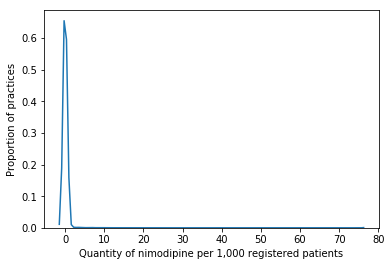

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.kdeplot(data["quantity_per_1000"], bw=0.5, legend=False)

plt.ylabel("Proportion of practices")
plt.xlabel("Quantity of nimodipine per 1,000 registered patients")

plt.show()

### Calculate percentage of practices with zero quantity per 1000

In [21]:
c = pd.DataFrame(data.groupby("quantity_per_1000")["practice"].count())
c / c.sum()

,practice
quantity_per_1000,
0.000000,0.991012
0.487101,0.000145
0.570389,0.000145
0.820996,0.000145
0.876150,0.000145
0.882321,0.000145
1.186838,0.000145
1.224847,0.000145
1.237569,0.000145


## get practice names to verify contact details

In [4]:
# Import dataset from BigQuery
from ebmdatalab import bq
GBQ_PROJECT_ID = '620265099307'

sql_prac = '''
SELECT code, name FROM ebmdatalab.hscic.practices where setting = 4
'''

prac = bq.cached_read(sql_prac, csv_path='prac.csv', use_cache=False)  # add `use_cache=False` to override

prac.head()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,code,name
0,A83005,WHINFIELD MEDICAL PRACTICE
1,A83013,NEASHAM ROAD SURGERY
2,A83040,CLIFTON COURT MEDICAL PRACTICE
3,A83641,PARKGATE SURGERY
4,A83070,ST GEORGE'S MEDICAL PRACTICE


In [7]:
contacts = agg[["practice"]].merge(prac, left_on="practice", right_on="code", how="left").drop("code",axis=1)

contacts.to_csv("contacts_request.csv")

contacts

,practice,name
0,A82036,THE LAKES MEDICAL PRACTICE
1,A83047,DENMARK STREET SURGERY
2,B82005,PRIORY MEDICAL GROUP
3,B86081,BELLBROOKE SURGERY
4,C81044,WHITTINGTON MOOR SURGERY
5,C81110,WELLBROOK MEDICAL CENTRE
6,C82027,THE OLD SCHOOL SURGERY
7,C82051,NEWBOLD VERDON MED.PRACT.
8,C86007,THE BURNS PRACTICE
9,C87015,WICKERSLEY HEALTH CENTRE
